### 1. 导入包

In [1]:
%matplotlib inline
import tensorflow as tf
print(tf.__version__)
from matplotlib import pyplot as plt
import random

2.3.0


### 2. 生成数据集
设训练数据集样本量为1000，特征数为2。给定随机生成的批量样本特征 $X\in\mathcal{R}^{1000\times2}$，使用线性回归模型的真实权重为 $\omega=[2, -3.4]^T$，偏差为 $b=4.2$，以及一个服从均值为0、标准差为0.01的正态分布的随机噪声项 $\epsilon$，来生成标签 $$y=X\omega+b+\epsilon$$
噪声代表了数据集中无意义的干扰。

In [10]:
def synthetic_data(w, b, num_examples):
    X = tf.random.normal([num_examples, len(w)], 0, 1)
    y = tf.matmul(X, w) + b
    y += tf.random.normal(y.shape, mean=0, stddev=0.01)
    return X, y

In [11]:
true_w = tf.constant([2, -3.4], shape=[2,1])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [12]:
print('features:', features[0], '\nlabel:', labels[0])

features: tf.Tensor([ 0.10969543 -0.555076  ], shape=(2,), dtype=float32) 
label: tf.Tensor([6.3010817], shape=(1,), dtype=float32)


分别生成两个特征和标签的散点图，观察线性关系

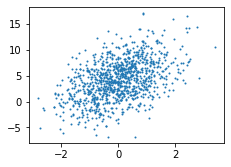

In [13]:
def set_figsize(figsize=(3.5, 2.5)):
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features[:, 0], labels, 1)

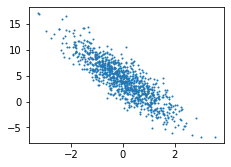

In [14]:
plt.scatter(features[:, 1], labels, 1)

### 3. 读取数据集
小批量随机梯度下降
训练数据集时要对数据集进行遍历，每次抽取一个小批量，用来更新模型参数。
定义一个函数，打乱数据集中的样本，并以小批量方式获取数据。

In [17]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = indices[i : min(i+batch_size, num_examples)]
        yield tf.gather(features, axis=0, indices=j), tf.gather(labels, axis=0, indices=j)

In [18]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tf.Tensor(
[[ 0.37313342  0.2428267 ]
 [-0.97925276 -0.39109635]
 [-0.37968466  1.0534719 ]
 [ 0.12106448  1.0339365 ]
 [ 0.5282528   1.1666031 ]
 [ 1.1984056   1.6556673 ]
 [ 0.50464964 -0.5049074 ]
 [-1.6152443  -1.5798284 ]
 [-1.0041084   0.05634249]
 [ 0.20450538 -1.0385259 ]], shape=(10, 2), dtype=float32) tf.Tensor(
[[ 4.102923  ]
 [ 3.578448  ]
 [-0.13633339]
 [ 0.9154755 ]
 [ 1.2872068 ]
 [ 0.9852767 ]
 [ 6.9196725 ]
 [ 6.3359284 ]
 [ 2.003068  ]
 [ 8.13361   ]], shape=(10, 1), dtype=float32)


### 4. 初始化模型参数
将权重初始化为均值为0，标准差为0.01的正太随机数，偏差初始化为0

In [20]:
w = tf.Variable(tf.random.normal((len(true_w), 1), mean=0, stddev=0.01))
b = tf.Variable(tf.zeros((1, )))

### 5. 定义模型

In [21]:
def linreg(X, w, b):
    return tf.matmul(X, w) + b

### 6. 定义损失函数

In [22]:
def squared_loss(y_hat, y):
    return (y_hat - tf.reshape(y, y_hat.shape)) ** 2 / 2

### 7. 定义优化算法
`sgd`函数实现小批量随机梯度下降，通过不断迭代模型参数来优化损失函数。
由于自动求梯度模块求得的是一个批量样本的梯度和，将它除以批量的大小得到平均值。

In [23]:
def sgd(params, lr, batch_size, grads):
    for i, param in enumerate(params):
        param.assign_sub(lr * grads[i] / batch_size)
        # 等价于 param = param - lr * grads[i] / batch_size

`tf.assign()` <br>
`tf.assign_add()` <br>
`tf.assign_sub()` <br>
用法

### 8. 训练模型


In [27]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [28]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with tf.GradientTape() as t:
            t.watch([w, b])
            l = tf.reduce_sum(loss(net(X, w, b), y))
        grads = t.gradient(l, [w, b])
        sgd([w, b], lr, batch_size, grads)
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' %(epoch+1, tf.reduce_mean(train_l)))

epoch 1, loss 0.042487
epoch 2, loss 0.000169
epoch 3, loss 0.000051


In [31]:
print(w)

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 1.9989198],
       [-3.4000285]], dtype=float32)>


In [32]:
print(b)

<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([4.199573], dtype=float32)>


学tf2，先搞搞张量是怎么回事